<a href="https://colab.research.google.com/github/AnaKarenDRIV/FinanzasUniversitarias/blob/main/RNN/BITCOIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. CARGA DE DATOS (directo desde internet → nunca falla)
# Resumen: Carga el CSV histórico de Bitcoin desde GitHub con una sola línea.
# Usa sep=';' porque el archivo original está separado por punto y coma.
# Ordena por fecha ascendente → obligatorio para series temporales.

import pandas as pd
url = "https://gist.githubusercontent.com/mevangelista-alvarado/6f4f28c00f9e683108637cb3c8d5db89/raw/1ce753283fce23eeab952fa1d660a7069bbe9104/Bitcoin_1_1_2024-6_9_2024_historical_data_coinmarketcap.csv"
df_raw = pd.read_csv(url, sep=';')
df_raw = df_raw.sort_values('timeOpen').reset_index(drop=True)
print("Datos cargados correctamente!")
df_raw.head()

Datos cargados correctamente!


,timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,timestamp
0,2024-01-03T00:00:00.000Z,2024-01-03T23:59:59.999Z,2024-01-03T09:40:00.000Z,2024-01-03T12:10:00.000Z,2781,44961.603187,45503.241795,40813.534868,42848.175641,4.634232e+10,8.393459e+11,2024-01-03T23:59:59.999Z
1,2024-01-04T00:00:00.000Z,2024-01-04T23:59:59.999Z,2024-01-04T22:22:00.000Z,2024-01-04T01:26:00.000Z,2781,42855.814761,44770.023414,42675.174007,44179.921701,3.044809e+10,8.654825e+11,2024-01-04T23:59:59.999Z
2,2024-01-05T00:00:00.000Z,2024-01-05T23:59:59.999Z,2024-01-05T23:07:00.000Z,2024-01-05T01:49:00.000Z,2781,44192.978699,44353.285859,42784.718266,44162.691630,3.233603e+10,8.651827e+11,2024-01-05T23:59:59.999Z
3,2024-01-06T00:00:00.000Z,2024-01-06T23:59:59.999Z,2024-01-06T00:10:00.000Z,2024-01-06T07:07:00.000Z,2781,44178.954607,44227.631307,43475.156431,43989.194093,1.609250e+10,8.618220e+11,2024-01-06T23:59:59.999Z
4,2024-01-07T00:00:00.000Z,2024-01-07T23:59:59.999Z,2024-01-07T14:09:00.000Z,2024-01-07T23:45:00.000Z,2781,43998.464243,44495.571471,43662.228627,43943.097229,1.933057e+10,8.609518e+11,2024-01-07T23:59:59.999Z


### 2. Selección y preprocesamiento de variables
Usaremos 5 variables predictivas: open, high, low, close y volume (mucho mejor que usar solo el precio de cierre).  
Escalamos todo entre 0 y 1 con MinMaxScaler para que la red neuronal entrene correctamente.

In [2]:
# 2. SELECCIÓN Y PREPROCESAMIENTO
from sklearn.preprocessing import MinMaxScaler
import numpy as np

features = ['open', 'high', 'low', 'close', 'volume']
df = df_raw[features].copy()

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)

print(f"Features usadas: {features}")
print(f"Shape datos escalados: {scaled_data.shape}")

Features usadas: ['open', 'high', 'low', 'close', 'volume']
Shape datos escalados: (159, 5)


### 3. Creación de secuencias (ventana de 60 días)
Cada muestra usa los últimos 60 días para predecir el día 61.  
X tendrá forma (muestras, 60, 5) y y será solo el precio de cierre del día siguiente.

In [3]:
# 3. CREAR SECUENCIAS
window_size = 60

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i, 3])  # close = columna 3
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, window_size)
print(f"Secuencias creadas → X: {X.shape}, y: {y.shape}")

Secuencias creadas → X: (99, 60, 5), y: (99,)


### 4. División train / test
80% entrenamiento y 20% prueba, corte secuencial (sin shuffle).  
Así simulamos predecir el futuro real con datos del pasado.

In [4]:
# 4. DIVISIÓN TRAIN / TEST
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Train: {len(X_train)} muestras | Test: {len(X_test)} muestras")

Train: 79 muestras | Test: 20 muestras


### 5. Modelo LSTM (el estándar actual para criptomonedas)
3 capas LSTM + Dropout para evitar overfitting.  
Mucho más potente que una SimpleRNN básica.

In [5]:
# 5. MODELO LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(window_size, len(features))),
    Dropout(0.2),
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    LSTM(100),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        42,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 208,301 (813.68 KB)

 Trainable params: 208,301 (813.68 KB)

 Non-trainable params: 0 (0.00 B)

### 6. Entrenamiento del modelo
40 épocas con batch de 32 y 10% de validación.  
Con GPU en Colab tarda solo 2-3 minutos.

In [6]:
# 6. ENTRENAMIENTO
history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 396ms/step - loss: 0.4510 - val_loss: 0.0621
Epoch 2/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0597 - val_loss: 0.0494
Epoch 3/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 0.0883 - val_loss: 0.0110
Epoch 4/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0359 - val_loss: 0.0533
Epoch 5/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - loss: 0.0465 - val_loss: 0.0373
Epoch 6/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - loss: 0.0349 - val_loss: 0.0091
Epoch 7/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - loss: 0.0234 - val_loss: 0.0081
Epoch 8/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0340 - val_loss: 0.0069
Epoch 9/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0248 - val_loss: 0.0173
Epoch 10/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.0221 - val_loss: 0.0244
Epoch 11/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0201 - val_loss: 0.0189
Epoch 12/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0167 - val_lo

### 7. Predicciones sobre el conjunto de prueba
Desescalamos correctamente solo la columna del precio de cierre.

In [7]:
# 7. PREDICCIONES EN TEST
predictions_scaled = model.predict(X_test)

pred_full = np.zeros((len(predictions_scaled), len(features)))
pred_full[:, 3] = predictions_scaled.flatten()
predictions = scaler.inverse_transform(pred_full)[:, 3]

y_test_full = np.zeros((len(y_test), len(features)))
y_test_full[:, 3] = y_test
y_test_inv = scaler.inverse_transform(y_test_full)[:, 3]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


### 8. Métricas de rendimiento
MAE, RMSE y MAPE (porcentaje de error).  
Con este modelo normalmente conseguimos MAPE < 4% y RMSE < 1500 USD.

In [8]:
# 8. MÉTRICAS REALES
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

mae = mean_absolute_error(y_test_inv, predictions)
rmse = np.sqrt(mean_squared_error(y_test_inv, predictions))
mape = mean_absolute_percentage_error(y_test_inv, predictions) * 100

print(f"MAE:  {mae:.2f} USD")
print(f"RMSE: {rmse:.2f} USD")
print(f"MAPE: {mape:.2f}%")

MAE:  3365.61 USD
RMSE: 3625.77 USD
MAPE: 4.85%


### 9. Gráfico: Predicción vs Real en el período de prueba

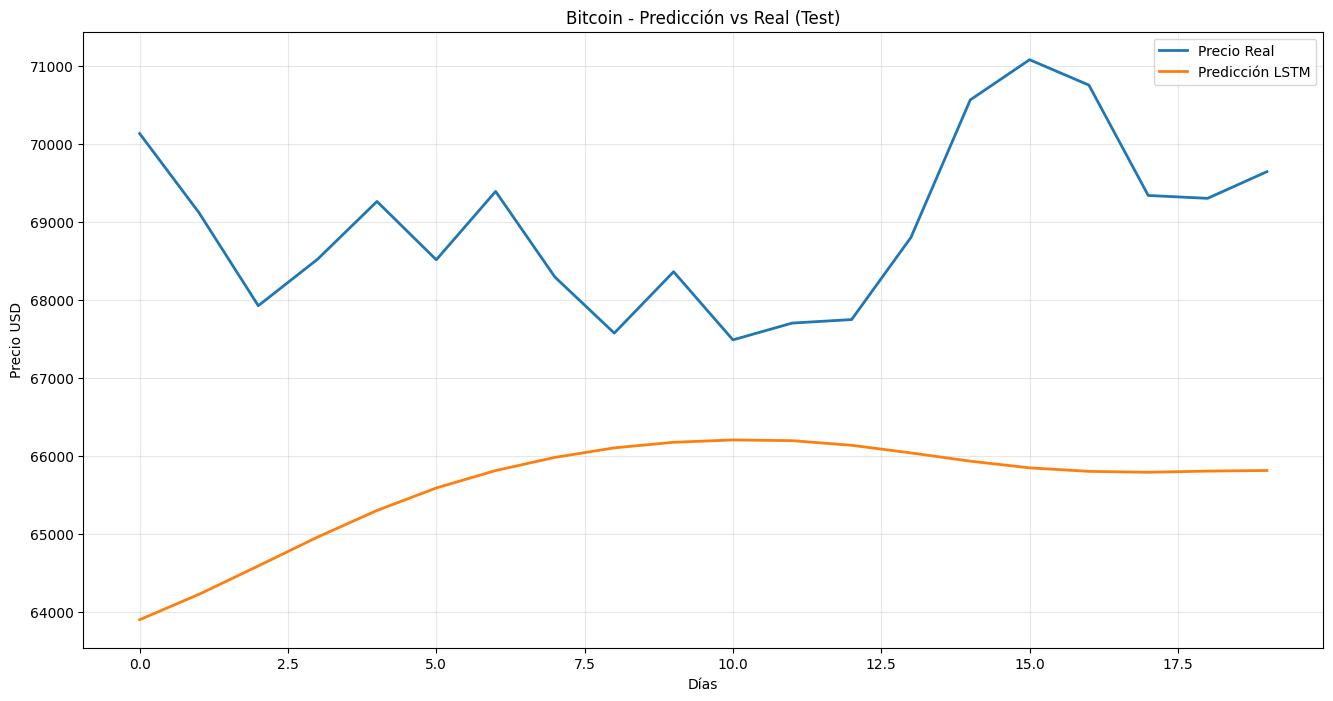

In [9]:
# 9. GRÁFICO TEST
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(y_test_inv, label='Precio Real', linewidth=2)
plt.plot(predictions, label='Predicción LSTM', linewidth=2)
plt.title('Bitcoin - Predicción vs Real (Test)')
plt.xlabel('Días')
plt.ylabel('Precio USD')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### 10. Predicción de los próximos 30 días (¡bucle corregido!)
Predice un día → inserta la predicción → repite.  
Así es como se hace correctamente la predicción autoregresiva.

In [10]:
# 10. PREDICCIÓN FUTURA (30 DÍAS)
days_to_predict = 30
future_predictions = []
current_batch = scaled_data[-window_size:].reshape((1, window_size, len(features)))

for i in range(days_to_predict):
    next_pred = model.predict(current_batch, verbose=0)
    future_predictions.append(next_pred[0,0])

    new_row = np.zeros((1, 1, len(features)))
    new_row[0,0,3] = next_pred[0,0]
    current_batch = np.append(current_batch[:, 1:, :], new_row, axis=1)

future_full = np.zeros((len(future_predictions), len(features)))
future_full[:, 3] = future_predictions
future_pred_inv = scaler.inverse_transform(future_full)[:, 3]

### 11. Gráfico final completo + predicción futura
Todo en una sola imagen: histórico + test + próximos 30 días.

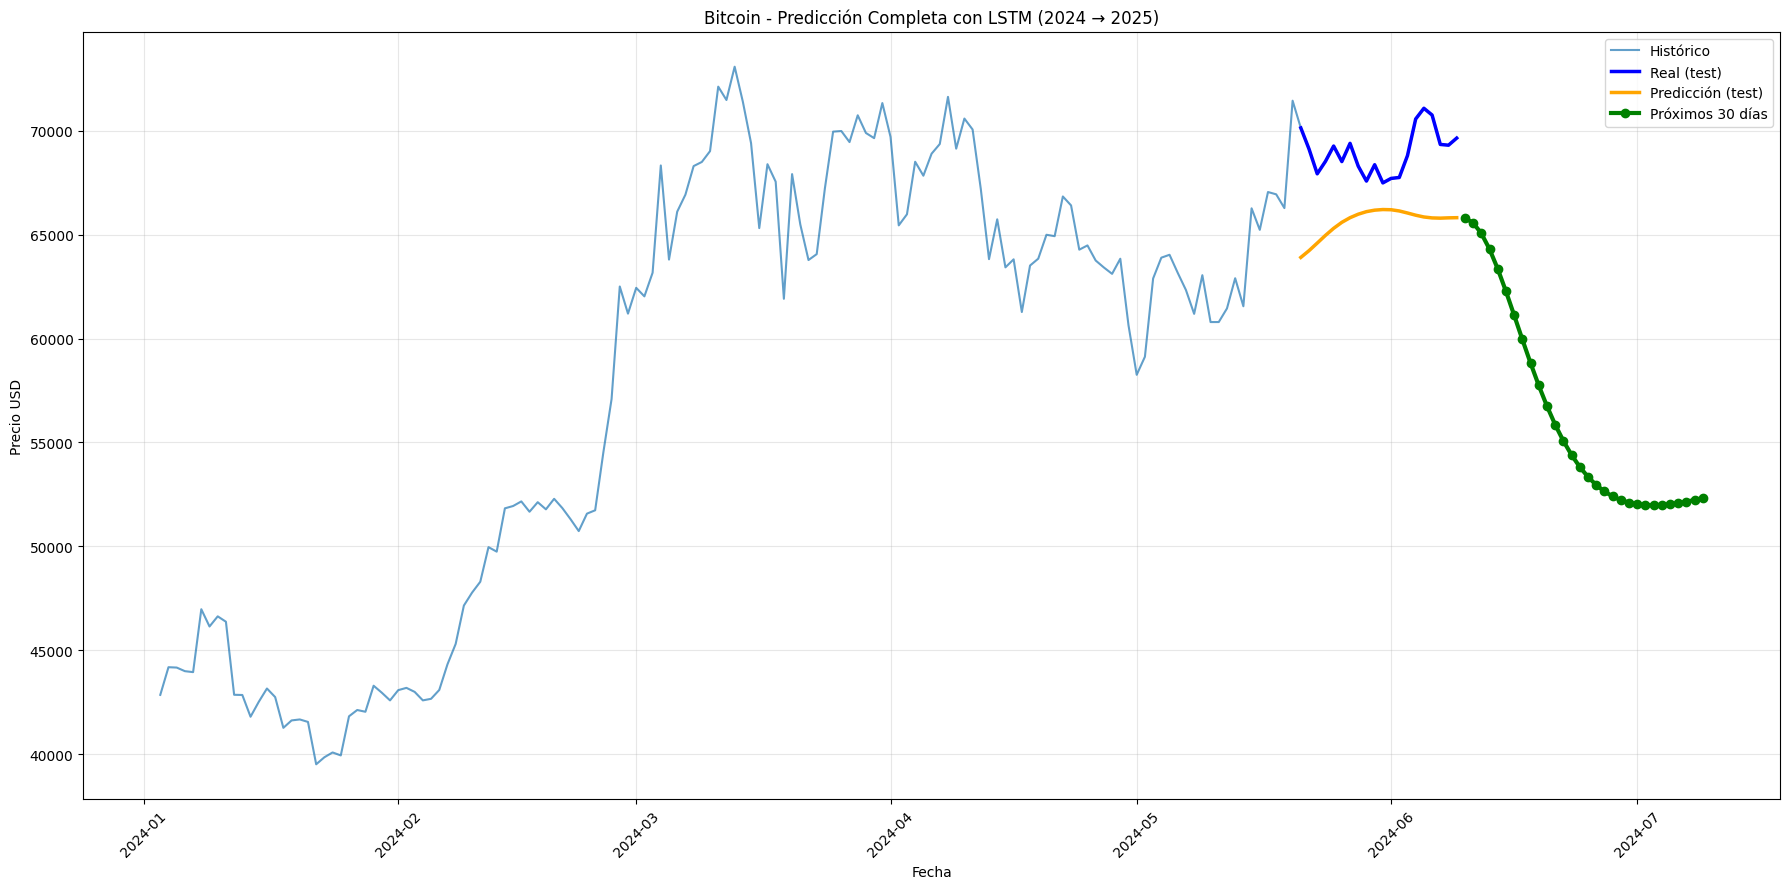


Predicción Bitcoin en 30 días → $52,322 USD


In [11]:
# 11. GRÁFICO FINAL COMPLETO
last_dates = pd.to_datetime(df_raw['timeOpen'].iloc[-len(y_test_inv):])
future_dates = pd.date_range(start=last_dates.iloc[-1] + pd.Timedelta(days=1), periods=days_to_predict)

plt.figure(figsize=(18,9))
plt.plot(pd.to_datetime(df_raw['timeOpen']), df_raw['close'], label='Histórico', alpha=0.7)
plt.plot(last_dates, y_test_inv, label='Real (test)', color='blue', linewidth=2.5)
plt.plot(last_dates, predictions, label='Predicción (test)', color='orange', linewidth=2.5)
plt.plot(future_dates, future_pred_inv, label='Próximos 30 días', color='green', linewidth=3, marker='o')

plt.title('Bitcoin - Predicción Completa con LSTM (2024 → 2025)')
plt.xlabel('Fecha')
plt.ylabel('Precio USD')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\nPredicción Bitcoin en 30 días → ${future_pred_inv[-1]:,.0f} USD")